# Carga y evaluación de los modelos

Descomprimimos la carpeta con los modelos

# Pasos previos

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf
import seaborn as sns   
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

fecha_inicio_train = '2010-01-01'
fecha_fin_train = '2019-01-01'
fecha_inicio_test = '2019-01-02'
fecha_fin_test = '2019-05-01'

datos_tesla = yf.download('TSLA', start=fecha_inicio_train, end=fecha_fin_train)
datos_sp500 = yf.download('^GSPC', start=fecha_inicio_train, end=fecha_fin_train)
datos_bitcoin = yf.download('BTC-USD', start=fecha_inicio_train, end=fecha_fin_train)
datos_petroleo = yf.download('CL=F', start=fecha_inicio_train, end=fecha_fin_train)

datos_tesla = datos_tesla.loc[:,'Adj Close'].copy() 
datos_sp500 = datos_sp500.loc[:,'Adj Close'].copy()
datos_bitcoin = datos_bitcoin.loc[:,'Adj Close'].copy()
datos_petroleo = datos_petroleo.loc[:,'Adj Close'].copy()

scaler_tesla =  MinMaxScaler(feature_range=(0,1))
scaler_sp500 =  MinMaxScaler(feature_range=(0,1))
scaler_bitcoin =  MinMaxScaler(feature_range=(0,1))
scaler_petroleo =  MinMaxScaler(feature_range=(0,1))

datos_tesla = scaler_tesla.fit_transform(np.array(datos_tesla).reshape(-1,1))
datos_sp500 = scaler_sp500.fit_transform(np.array(datos_sp500).reshape(-1,1))
datos_bitcoin = scaler_bitcoin.fit_transform(np.array(datos_bitcoin).reshape(-1,1))
datos_petroleo = scaler_petroleo.fit_transform(np.array(datos_petroleo).reshape(-1,1))

print(datos_tesla.shape,
      datos_sp500.shape,
      datos_bitcoin.shape,
      datos_petroleo.shape)

def create_time_series_dataset(data, time_steps):
    """
    Crea un conjunto de datos de series temporales para el entrenamiento de modelos de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene dos arreglos numpy. El primer arreglo contiene las etiquetas de salida (y) y el segundo arreglo contiene las ventanas de tiempo de entrada (X).
    """

    X = []
    y = []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])    # Se crea una ventana de tiempo de longitud time_steps en la serie temporal de entrada
        y.append(data[i+time_steps])      # Se obtiene la etiqueta de salida correspondiente a la ventana de tiempo
    return np.array(y), np.array(X)      # Se devuelven las etiquetas de salida y las ventanas de tiempo de entrada como arreglos numpy en una tupla


def preparar_datos_entrenamiento(datos, pasos):
    """
    Prepara los datos de entrenamiento para modelos de series temporales.

    Parámetros:
        - datos (array-like): Serie temporal de entrada.
        - pasos (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene cuatro arreglos numpy. Los primeros dos arreglos contienen las etiquetas de salida (y) y las ventanas de tiempo de entrada (X) respectivamente. Los otros dos arreglos contienen las ventanas de tiempo de entrada remodeladas (X_reg) para su uso en modelos que requieren datos en 2D.
    """

    y, X = create_time_series_dataset(datos, pasos)                    # Se crea el conjunto de datos de series temporales
    indices_barajados = np.random.permutation(len(y))                  # Se barajan los índices de las muestras
    X_train, y_train = X[indices_barajados], y[indices_barajados]      # Se obtienen las ventanas de tiempo y etiquetas de salida barajadas

    X_train_reg = X_train.reshape(X_train.shape[0], -1)                # Se remodelan las ventanas de tiempo para su uso en modelos que requieren datos en 2D

    return X_train, y_train, X_train_reg, y_train


datos_tesla_test = yf.download('TSLA', start=fecha_inicio_test, end=fecha_fin_test)
datos_sp500_test = yf.download('^GSPC', start=fecha_inicio_test, end=fecha_fin_test)
datos_bitcoin_test = yf.download('BTC-USD', start=fecha_inicio_test, end=fecha_fin_test) 
datos_petroleo_test = yf.download('CL=F', start=fecha_inicio_test, end=fecha_fin_test)

datos_tesla_test = datos_tesla_test.loc[:,'Adj Close'].copy() # todo ajustado
datos_sp500_test = datos_sp500_test.loc[:,'Adj Close'].copy()
datos_bitcoin_test = datos_bitcoin_test.loc[:,'Adj Close'].copy()
datos_petroleo_test = datos_petroleo_test.loc[:,'Adj Close'].copy()

datos_tesla_test = scaler_tesla.transform(np.array(datos_tesla_test).reshape(-1,1))
datos_sp500_test = scaler_sp500.transform(np.array(datos_sp500_test).reshape(-1,1))
datos_bitcoin_test = scaler_bitcoin.transform(np.array(datos_bitcoin_test).reshape(-1,1))
datos_petroleo_test = scaler_petroleo.transform(np.array(datos_petroleo_test).reshape(-1,1))

def evaluate_model(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:31], label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:30], label=name, color='blue')
    ax.set_title(name)

def evaluate_model_seguidos(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales para predicciones continuas.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.
        - dias (int): Número de días a mostrar en la gráfica.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred, label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test, label=name, color='blue')
    ax.set_title(name)

def predict_n_days(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando un modelo de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        aux = X.reshape(-1, 1).T           # Se ajusta la forma de las características de entrada según el modelo
        y_pred = model.predict(aux)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy

def predict_n_days_red(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando redes neuronales.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        X = X.reshape(X.shape[1], X.shape[0] , 1)
        y_pred = model.predict(X, verbose=False)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        data = data.reshape(-1, 1)

        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(2142, 1) (2264, 1) (1567, 1) (2262, 1)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Redes neuronales

In [2]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 30
pasos_sp500 = 30
pasos_bitcoin = 30
pasos_petroleo = 30

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)

# LSTM

2/2 [==============================] - 0s 19ms/step
Tesla (TSLA)
RMSE:  0.5423793835611935
MSE:  0.29417539571222034
MAE:  0.40725818047156703
R²:  0.7845438471886189


2/2 [==============================] - 0s 13ms/step
SP500 (^GSPC)
RMSE:  25.784152474224715
MSE:  664.8225188140685
MAE:  22.424842247596153
R²:  0.7945480000962439


3/3 [==============================] - 0s 35ms/step
Bitcoin (BTC-USD)
RMSE:  131.4648356789056
MSE:  17283.003020081647
MAE:  82.00897011060395
R²:  0.9579326076499411


2/2 [==============================] - 0s 6ms/step
Petroleo (CL=F)
RMSE:  0.8101140403132469
MSE:  0.6562847583126529
MAE:  0.6618242263793953
R²:  0.9455440003318211




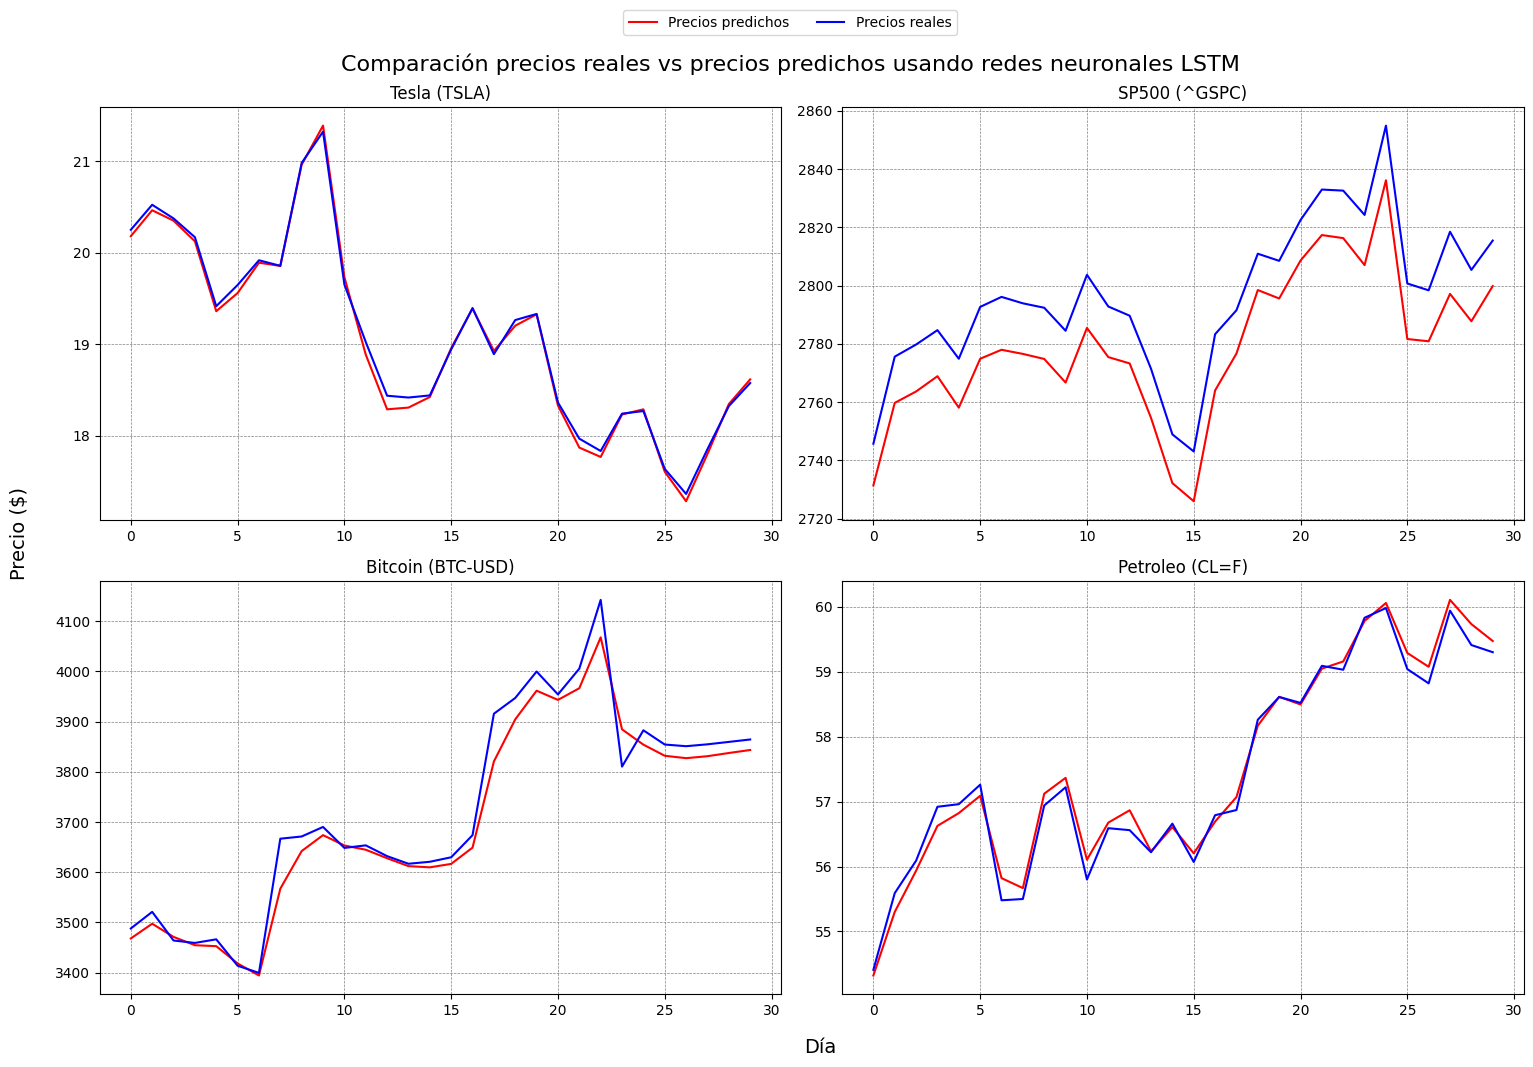

Tesla (TSLA)
RMSE:  1.8413327670174564
MSE:  3.390506358892162
MAE:  1.657283401489258
R²:  -12.638309851760122


SP500 (^GSPC)
RMSE:  71.730109102066
MSE:  5145.2085517942905
MAE:  70.5622802734375
R²:  -8.339055157298926


Bitcoin (BTC-USD)
RMSE:  355.40389159725777
MSE:  126311.92616247537
MAE:  344.16369628906256
R²:  -66.11966645904694


Petroleo (CL=F)
RMSE:  6.320205623592903
MSE:  39.94499912449536
MAE:  6.1755741119384755
R²:  -14.857015343129886




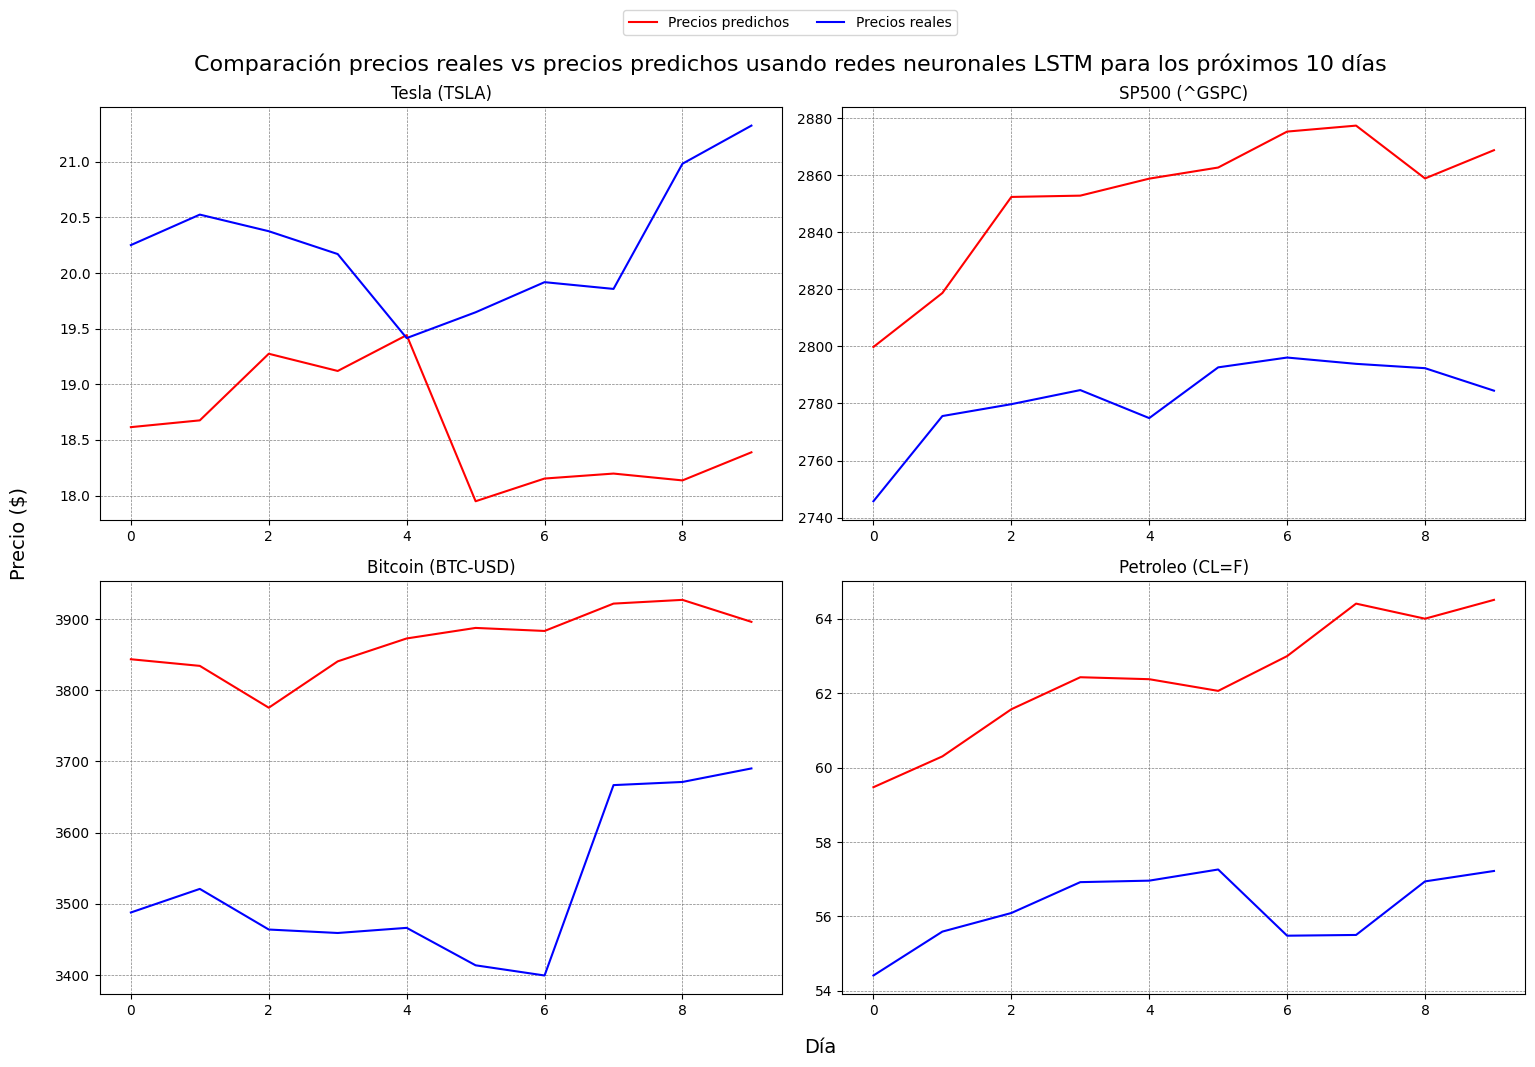

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_tesla = tf.keras.models.load_model('modelos/lstm_tesla.h5')
y_pred_tesla_t = lstm_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

lstm_sp500 = tf.keras.models.load_model('modelos/lstm_sp500.h5')
y_pred_sp500_t = lstm_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

lstm_bitcoin = tf.keras.models.load_model('modelos/lstm_bitcoin.h5')
y_pred_bitcoin_t = lstm_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

lstm_petroleo = tf.keras.models.load_model('modelos/lstm_petroleo.h5')
y_pred_petroleo_t = lstm_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

dias = 10

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[pasos_tesla:pasos_tesla*3], pasos_tesla, dias, lstm_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[pasos_sp500:pasos_sp500*3], pasos_sp500, dias, lstm_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[pasos_bitcoin:pasos_bitcoin*3], pasos_bitcoin, dias, lstm_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[pasos_petroleo:pasos_petroleo*3], pasos_petroleo, dias, lstm_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM para los próximos 10 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

In [4]:
lstm_tesla.summary()

Model: "sequential_965"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2895 (LSTM)            (None, None, 256)         264192    
                                                                 
 lstm_2896 (LSTM)            (None, None, 256)         525312    
                                                                 
 lstm_2897 (LSTM)            (None, 256)               525312    
                                                                 
 dense_965 (Dense)           (None, 1)                 257       
                                                                 
Total params: 1,315,073
Trainable params: 1,315,073
Non-trainable params: 0
_________________________________________________________________


In [5]:
lstm_sp500.summary()

Model: "sequential_966"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2898 (LSTM)            (None, None, 128)         66560     
                                                                 
 lstm_2899 (LSTM)            (None, None, 128)         131584    
                                                                 
 lstm_2900 (LSTM)            (None, 128)               131584    
                                                                 
 dense_966 (Dense)           (None, 1)                 129       
                                                                 
Total params: 329,857
Trainable params: 329,857
Non-trainable params: 0
_________________________________________________________________


In [6]:
lstm_bitcoin.summary()

Model: "sequential_967"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2901 (LSTM)            (None, None, 256)         264192    
                                                                 
 lstm_2902 (LSTM)            (None, None, 256)         525312    
                                                                 
 lstm_2903 (LSTM)            (None, 256)               525312    
                                                                 
 dense_967 (Dense)           (None, 1)                 257       
                                                                 
Total params: 1,315,073
Trainable params: 1,315,073
Non-trainable params: 0
_________________________________________________________________


In [7]:
lstm_petroleo.summary()

Model: "sequential_968"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2904 (LSTM)            (None, None, 36)          5472      
                                                                 
 lstm_2905 (LSTM)            (None, None, 36)          10512     
                                                                 
 lstm_2906 (LSTM)            (None, 36)                10512     
                                                                 
 dense_968 (Dense)           (None, 1)                 37        
                                                                 
Total params: 26,533
Trainable params: 26,533
Non-trainable params: 0
_________________________________________________________________


# GRU

2/2 [==============================] - 0s 8ms/step
Tesla (TSLA)
RMSE:  0.5544331684717358
MSE:  0.3073961383016082
MAE:  0.413651521389301
R²:  0.7775572297967728


2/2 [==============================] - 0s 3ms/step
SP500 (^GSPC)
RMSE:  24.15591313979184
MSE:  583.508139617168
MAE:  20.55711951622596
R²:  0.8208218505614857


3/3 [==============================] - 0s 8ms/step
Bitcoin (BTC-USD)
RMSE:  193.6284367584392
MSE:  37491.97152151689
MAE:  164.6599532566714
R²:  0.9156554226080393


2/2 [==============================] - 0s 5ms/step
Petroleo (CL=F)
RMSE:  1.351030719036775
MSE:  1.8252840037810252
MAE:  1.1971171452448919
R²:  0.8434067099700688




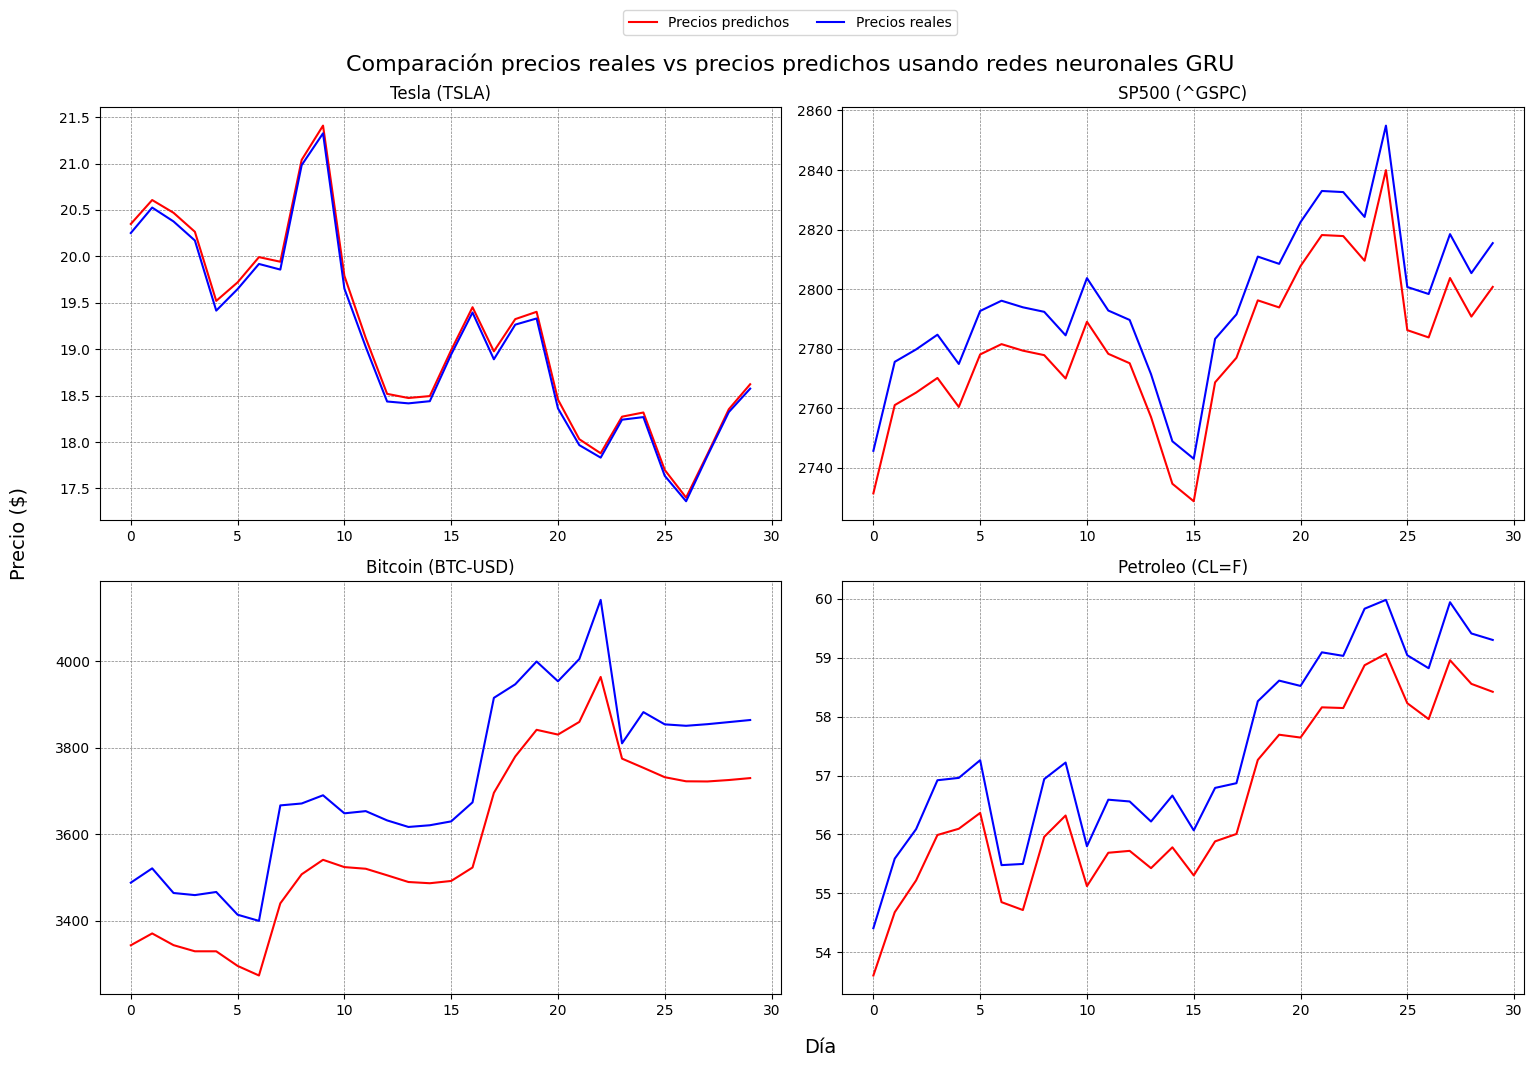

Tesla (TSLA)
RMSE:  0.9628543778325465
MSE:  0.9270885529113002
MAE:  0.7986270904541015
R²:  -12.810680473435383


SP500 (^GSPC)
RMSE:  118.092938412999
MSE:  13945.942103016376
MAE:  106.423046875
R²:  -7.7295233391847304


Bitcoin (BTC-USD)
RMSE:  686.8674725444956
MSE:  471786.92483966344
MAE:  600.746728515625
R²:  -6.035688545904239


Petroleo (CL=F)
RMSE:  6.104686201213275
MSE:  37.26719361528377
MAE:  5.6975231170654315
R²:  -14.393352631395297




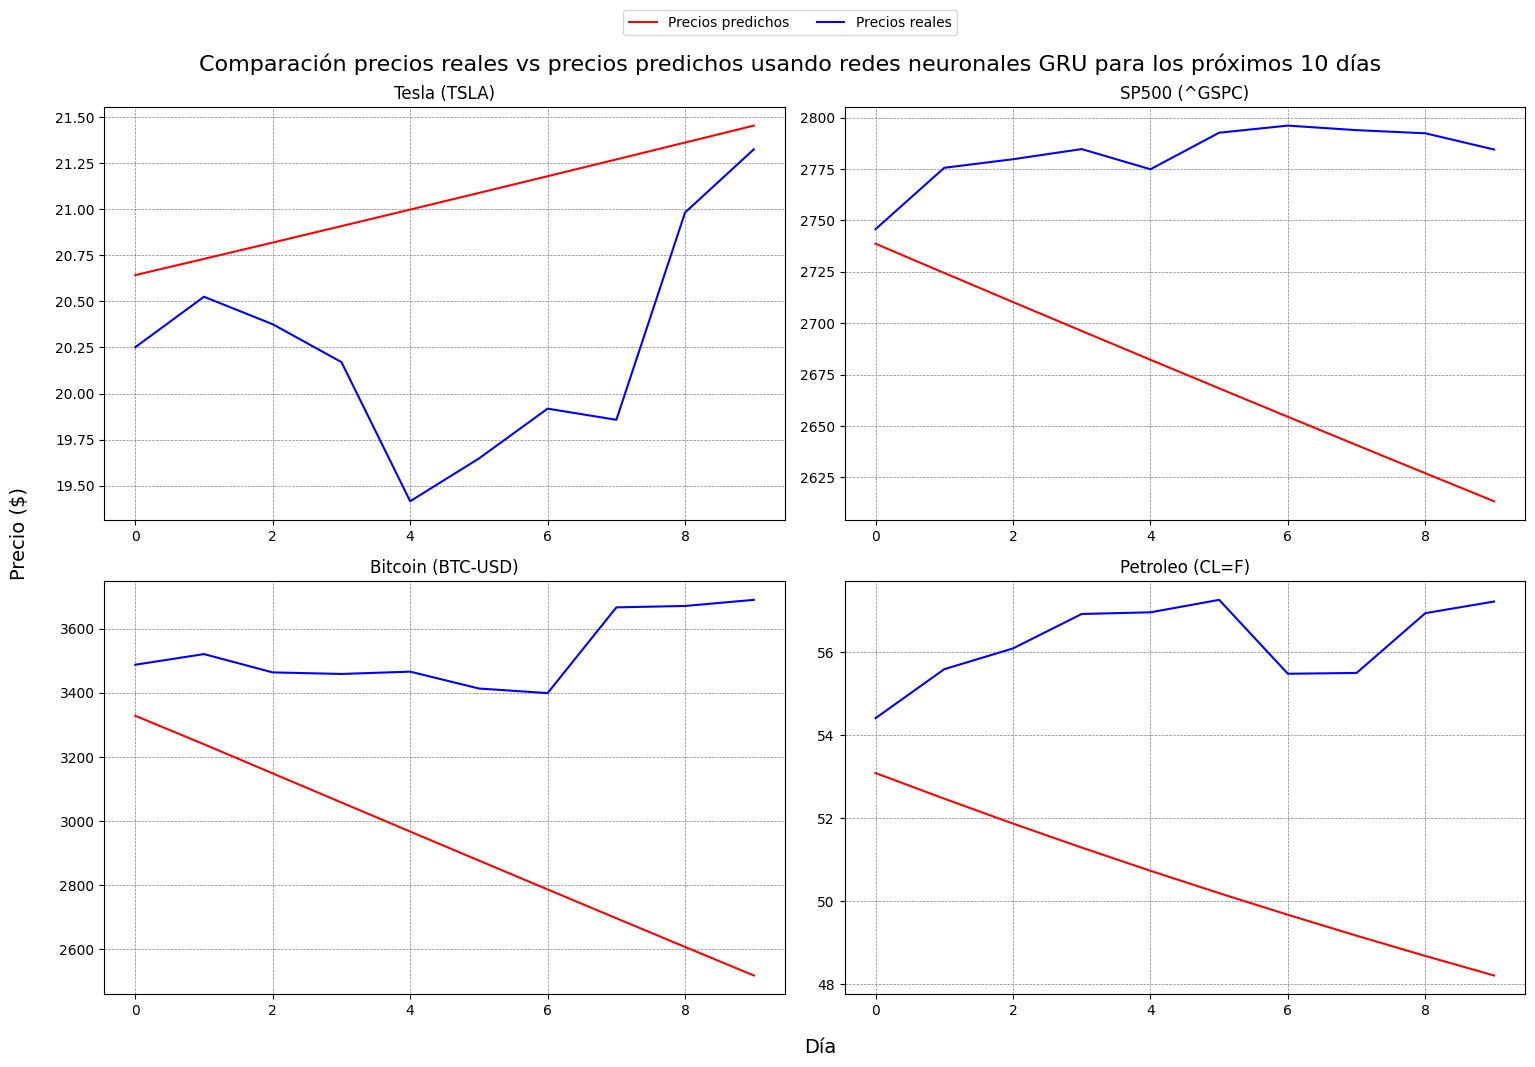

In [8]:

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

gru_tesla = tf.keras.models.load_model('modelos/gru_tesla.h5')
y_pred_tesla_t = gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

gru_sp500 = tf.keras.models.load_model('modelos/gru_sp500.h5')
y_pred_sp500_t = gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

gru_bitcoin = tf.keras.models.load_model('modelos/gru_bitcoin.h5')
y_pred_bitcoin_t = gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

gru_petroleo = tf.keras.models.load_model('modelos/gru_petroleo.h5')
y_pred_petroleo_t = gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

dias = 10

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU para los próximos 10 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

In [9]:
gru_tesla.summary()

Model: "sequential_1933"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2892 (GRU)              (None, None, 36)          4212      
                                                                 
 gru_2893 (GRU)              (None, None, 36)          7992      
                                                                 
 gru_2894 (GRU)              (None, 36)                7992      
                                                                 
 dense_1933 (Dense)          (None, 1)                 37        
                                                                 
Total params: 20,233
Trainable params: 20,233
Non-trainable params: 0
_________________________________________________________________


In [10]:
gru_sp500.summary()

Model: "sequential_1934"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2895 (GRU)              (None, 64)                12864     
                                                                 
 dense_1934 (Dense)          (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [11]:
gru_bitcoin.summary()

Model: "sequential_1935"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2907 (LSTM)            (None, None, 128)         66560     
                                                                 
 gru_2896 (GRU)              (None, 128)               99072     
                                                                 
 dense_1935 (Dense)          (None, 1)                 129       
                                                                 
Total params: 165,761
Trainable params: 165,761
Non-trainable params: 0
_________________________________________________________________


In [12]:
gru_petroleo.summary()

Model: "sequential_1936"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2897 (GRU)              (None, None, 36)          4212      
                                                                 
 gru_2898 (GRU)              (None, None, 36)          7992      
                                                                 
 gru_2899 (GRU)              (None, 36)                7992      
                                                                 
 dense_1936 (Dense)          (None, 1)                 37        
                                                                 
Total params: 20,233
Trainable params: 20,233
Non-trainable params: 0
_________________________________________________________________


# LSTM + GRU

2/2 [==============================] - 0s 11ms/step
Tesla (TSLA)
RMSE:  0.5714453620536736
MSE:  0.32654980181265414
MAE:  0.47257346373337966
R²:  0.7495785811316442


2/2 [==============================] - 0s 20ms/step
SP500 (^GSPC)
RMSE:  19.712916434000988
MSE:  388.5990743339062
MAE:  15.441810021033653
R²:  0.877950292490558


3/3 [==============================] - 0s 14ms/step
Bitcoin (BTC-USD)
RMSE:  115.86021986811734
MSE:  13423.59054788849
MAE:  63.52988390976127
R²:  0.969393409102219


2/2 [==============================] - 0s 10ms/step
Petroleo (CL=F)
RMSE:  0.9515840456103528
MSE:  0.905512195860166
MAE:  0.7798439906193663
R²:  0.9270074168144052




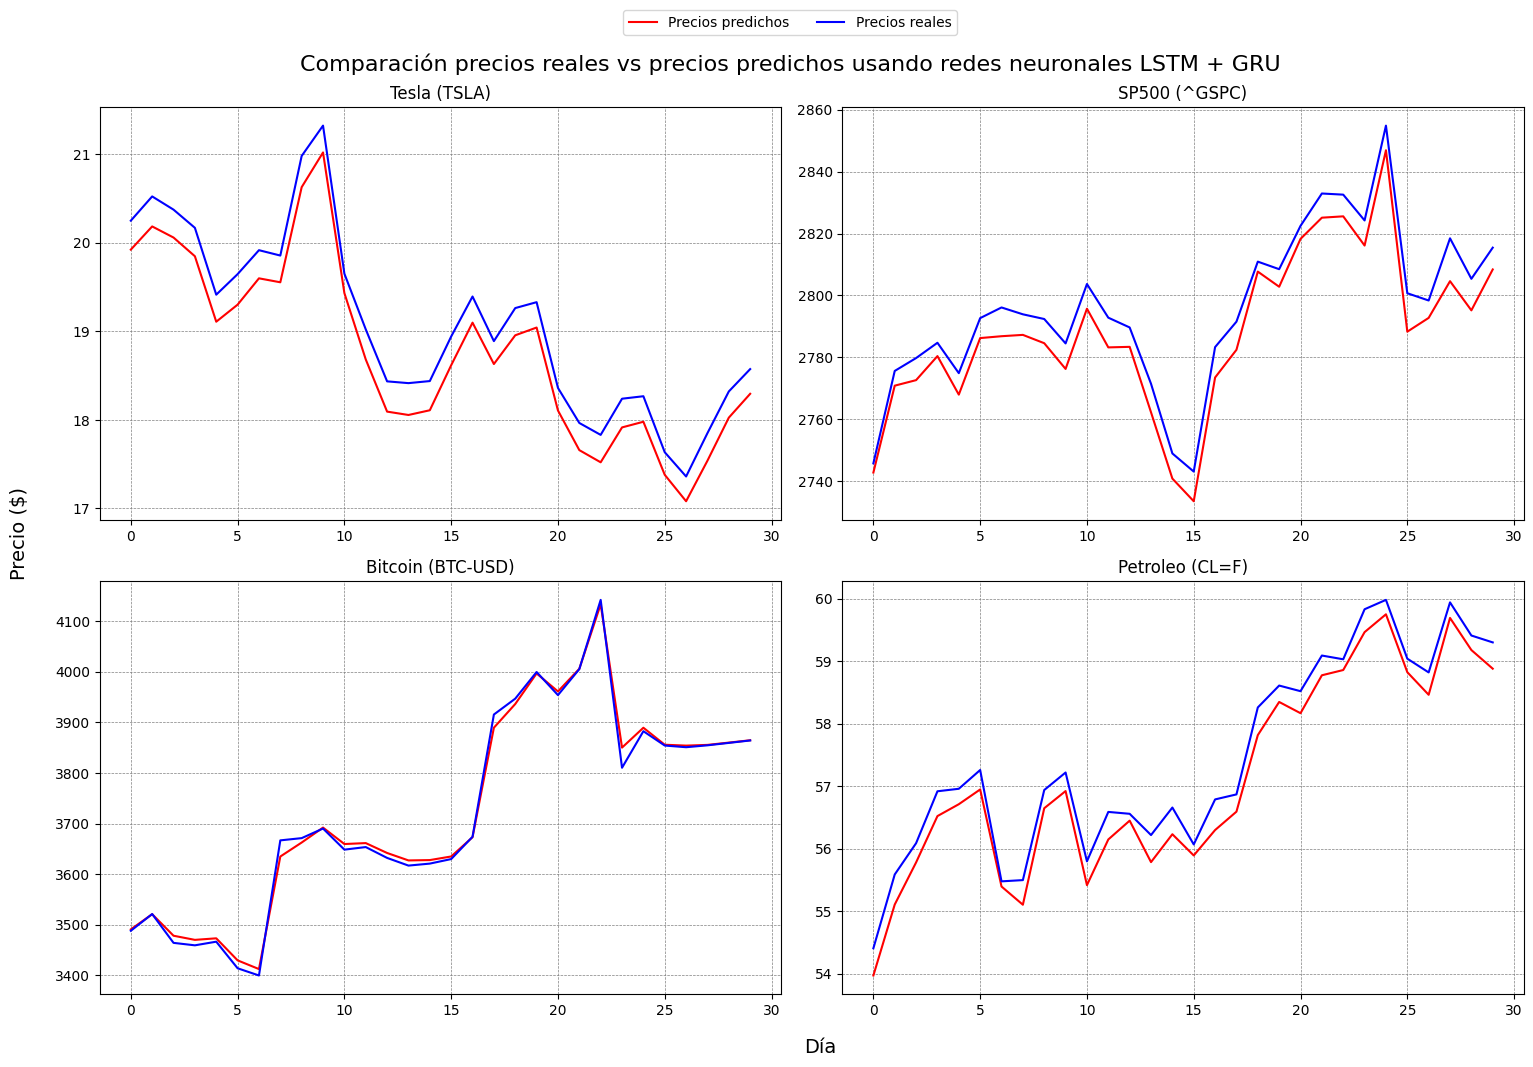

Tesla (TSLA)
RMSE:  1.8838034619502448
MSE:  3.548715483255728
MAE:  1.4654680252075196
R²:  -3.399533156671083


SP500 (^GSPC)
RMSE:  70.27414516009966
MSE:  4938.4554779827595
MAE:  63.0961181640625
R²:  -11.873317587847936


Bitcoin (BTC-USD)
RMSE:  100.19628416257264
MSE:  10039.295359987005
MAE:  80.25339355468745
R²:  -33.853558931061485


Petroleo (CL=F)
RMSE:  4.585192094880301
MSE:  21.023986546952806
MAE:  4.289403915405275
R²:  -22.92591966976703




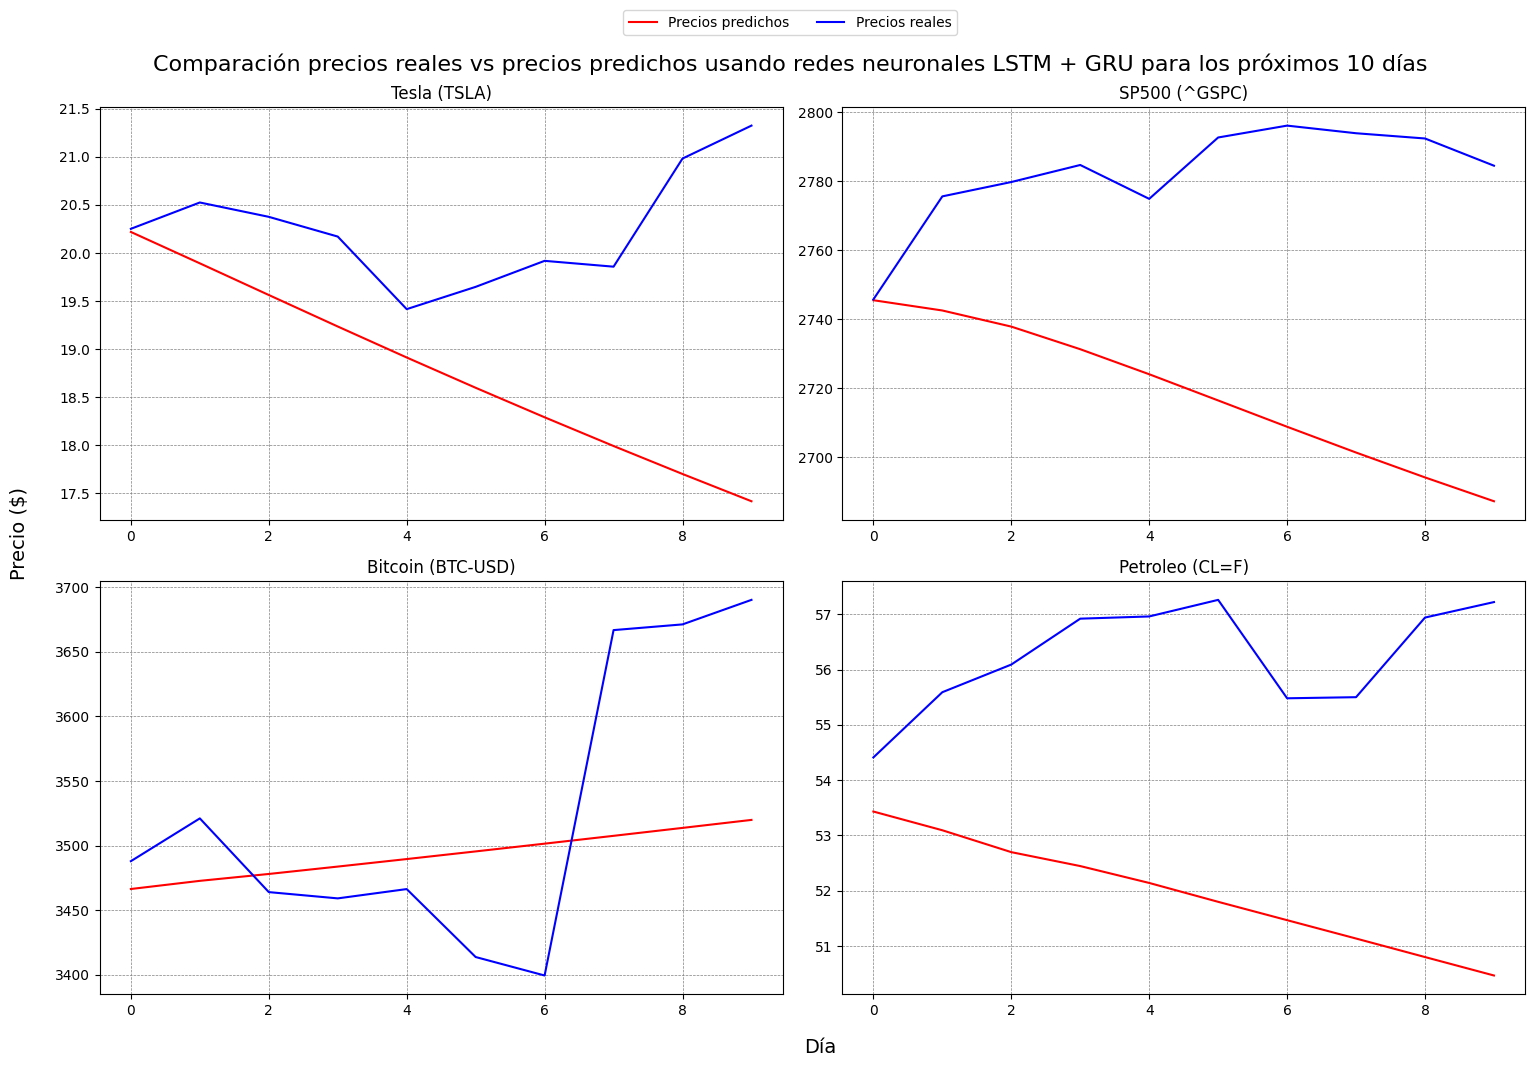

In [13]:

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_gru_tesla = tf.keras.models.load_model('modelos/lstm_gru_tesla.h5')
y_pred_tesla_t = lstm_gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

lstm_gru_sp500 = tf.keras.models.load_model('modelos/lstm_gru_sp500.h5')
y_pred_sp500_t = lstm_gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

lstm_gru_bitcoin = tf.keras.models.load_model('modelos/lstm_gru_bitcoin.h5')
y_pred_bitcoin_t = lstm_gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

lstm_gru_petroleo = tf.keras.models.load_model('modelos/lstm_gru_petroleo.h5')
y_pred_petroleo_t = lstm_gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM + GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

dias = 10

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, lstm_gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, lstm_gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, lstm_gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, lstm_gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM + GRU para los próximos 10 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

In [14]:
lstm_gru_tesla.summary()

Model: "sequential_2902"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4837 (LSTM)            (None, None, 256)         264192    
                                                                 
 gru_4829 (GRU)              (None, 256)               394752    
                                                                 
 dense_2902 (Dense)          (None, 1)                 257       
                                                                 
Total params: 659,201
Trainable params: 659,201
Non-trainable params: 0
_________________________________________________________________


In [15]:
lstm_gru_sp500.summary()

Model: "sequential_2903"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4838 (LSTM)            (None, None, 256)         264192    
                                                                 
 lstm_4839 (LSTM)            (None, None, 256)         525312    
                                                                 
 gru_4830 (GRU)              (None, None, 256)         394752    
                                                                 
 gru_4831 (GRU)              (None, 256)               394752    
                                                                 
 dense_2903 (Dense)          (None, 1)                 257       
                                                                 
Total params: 1,579,265
Trainable params: 1,579,265
Non-trainable params: 0
_________________________________________________________________


In [16]:
lstm_gru_bitcoin.summary()

Model: "sequential_2904"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4840 (LSTM)            (None, None, 256)         264192    
                                                                 
 gru_4832 (GRU)              (None, 256)               394752    
                                                                 
 dense_2904 (Dense)          (None, 1)                 257       
                                                                 
Total params: 659,201
Trainable params: 659,201
Non-trainable params: 0
_________________________________________________________________


In [17]:
lstm_gru_petroleo.summary()

Model: "sequential_2905"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4841 (LSTM)            (None, None, 256)         264192    
                                                                 
 gru_4833 (GRU)              (None, 256)               394752    
                                                                 
 dense_2905 (Dense)          (None, 1)                 257       
                                                                 
Total params: 659,201
Trainable params: 659,201
Non-trainable params: 0
_________________________________________________________________
